In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

import sys

sys.path.append('../')

from implementations import *

%load_ext autoreload
%autoreload 2

# **Load and clean the training data**

We load the training data.

In [5]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("../data")

print(f"The data has {x_train.shape[0]} samples and {x_train.shape[1]} features !")

The data has 328135 samples and 321 features !


For each feature, we clean the data so the values make more sense

We then clean the data by : 
- selecting the best 43 features with human decision and correlation analysis
- removing the nan values by the median of the rest of the feature for continuous values
- removing the nan values by the -1 for categorical features
- removing the features where the variance is zero since they are constants for all samples

In [6]:
feat = [20, 26, 27, 29, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 47, 48, 50, 57, 58, 61, 66, 69, 70, 
        71, 95, 100, 103, 108, 109, 138, 144, 157, 230, 231, 232, 234, 238, 248, 253, 257, 258, 304]

feat_cat = [20, 26, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 47, 48, 50, 57, 58, 61, 66, 69, 
            70, 71, 95, 100, 103, 108, 109, 138, 144, 157, 230, 231, 232, 234, 238, 257, 258]

feat_con = [27, 29, 248, 253, 304]

In [7]:
xt_feat = gen_clean(x_train, feat_cat, feat_con)
xt_feat = x_train[:, feat]
print(f"The data has now {xt_feat.shape[1]} features !")

The data has now 43 features !


# Linear regression 

We train our model using linear regression with mean-square error.

First, we separate our data in a training set(70%) and testing set(30%).

In [8]:
tx_tr, tx_te, y_tr, y_te = cross(xt_feat, y_train, 0.7)

print(f"tx_tr shape : {tx_tr.shape} ; tx_te shape : {tx_te.shape}")
print(f"       y_tr : {y_tr.shape}     ;        y_te : {y_te.shape}")

tx_tr shape : (229694, 43) ; tx_te shape : (98441, 43)
       y_tr : (229694,)     ;        y_te : (98441,)


Now we build our models for linear regression

In [9]:
y, tx = build_model_data(tx_tr, y_tr)
y_test, tx_test = build_model_data(tx_te, y_te)
print(f"The data has now {tx.shape[1]} features !")

The data has now 44 features !


## Training

Here we train our model using GD with MSE

In [10]:
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 2.4e-5

start_time = datetime.datetime.now()
w, loss = mean_squared_error_gd(y, tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 1.497533 seconds


### Computation of metrics

We first compute some metrics on the training data (60% of the total data)

In [22]:
pred_data = np.dot(tx, w)

pred_data[pred_data > 0] = 1
pred_data[pred_data <= 0] = -1

correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == -1))

tn = np.sum((pred_data == -1) & (y == -1))
fn = np.sum((pred_data == -1) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 91.19916062239326%
Precision: 21.428571428571427%
Recall : 0.014846340377097046%
F1-score : 0.029672123040403543%


Now we compute some metrics for our test data (40% of the total data)

In [21]:
pred_test = np.dot(tx_test, w)

pred_test[pred_test > 0] = 1
pred_test[pred_test <= 0] = -1

correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == -1))

tn = np.sum((pred_test == -1) & (y_test == -1))
fn = np.sum((pred_test == -1) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 91.08907873751791%
Precision: 0.0%
Recall : 0.0%
F1-score : 0.0%


### Feature analysis

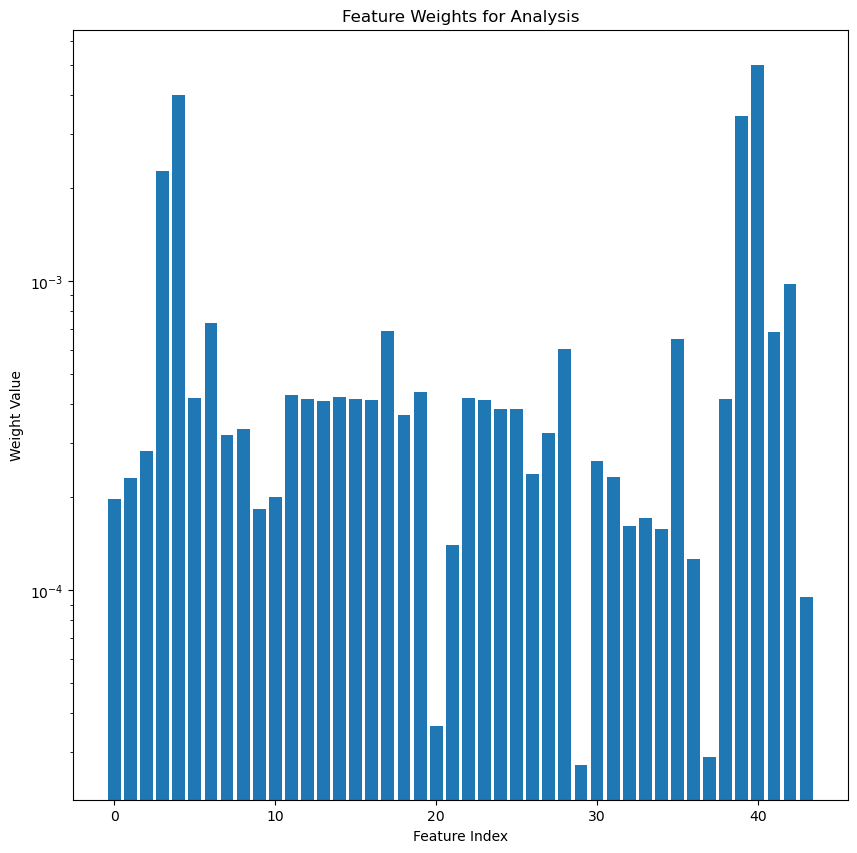

In [13]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(w)), np.abs(w))
plt.yscale('log')
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

# **Prediction on test data**

In [40]:
start_time = datetime.datetime.now()

tx_test = gen_clean(x_test, feat_cat, feat_con)
tx_test = tx_test[:, feat]
tx_te = np.c_[np.ones(tx_test.shape[0]), tx_test]

end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")
print(f"The data has {tx_test.shape[0]} samples and {tx_test.shape[1]} features !")

Execution time 0.387158 seconds
The data has 109379 samples and 43 features !


In [45]:
pred_te = np.dot(tx_te, w)

pred_te[pred_te > 0] = 1
pred_te[pred_te < 0] = -1

indices_one = np.where(pred_te == 1)

In [46]:
create_csv_submission(test_ids, pred_te, "../data/lin_reg.csv")